In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat

In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_stim_and_spikes(stim, spikes, dt, nt=120):
  """Show time series of stim intensity and spike counts.

  Args:
    stim (1D array): vector of stimulus intensities
    spikes (1D array): vector of spike counts
    dt (number): duration of each time step
    nt (number): number of time steps to plot

  """
  timepoints = np.arange(nt)
  time = timepoints * dt

  f, (ax_stim, ax_spikes) = plt.subplots(
    nrows=2, sharex=True, figsize=(8, 5),
  )
  ax_stim.plot(time, stim[timepoints])
  ax_stim.set_ylabel('Stimulus intensity')

  ax_spikes.plot(time, spikes[timepoints])
  ax_spikes.set_xlabel('Time (s)')
  ax_spikes.set_ylabel('Number of spikes')

  f.tight_layout()


def plot_glm_matrices(X, y, nt=50):
  """Show X and Y as heatmaps.

  Args:
    X (2D array): Design matrix.
    y (1D or 2D array): Target vector.

  """
  from matplotlib.colors import BoundaryNorm
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  Y = np.c_[y]  # Ensure Y is 2D and skinny

  f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(6, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )
  norm = BoundaryNorm([-1, -.2, .2, 1], 256)
  imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)

  ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    xticks=[4, 14, 24],
    xticklabels=['-20', '-10', '0'],
    ylabel="Time point (time bins)",
  )
  plt.setp(ax_x.spines.values(), visible=True)

  divx = make_axes_locatable(ax_x)
  caxx = divx.append_axes("right", size="5%", pad=0.1)
  cbarx = f.colorbar(imx, cax=caxx)
  cbarx.set_ticks([-.6, 0, .6])
  cbarx.set_ticklabels(np.sort(np.unique(X)))

  norm = BoundaryNorm(np.arange(y.max() + 1), 256)
  imy = ax_y.pcolormesh(Y[:nt], cmap="magma", norm=norm)
  ax_y.set(
    title="Y\n(spike count)",
    xticks=[]
  )
  ax_y.invert_yaxis()
  plt.setp(ax_y.spines.values(), visible=True)

  divy = make_axes_locatable(ax_y)
  caxy = divy.append_axes("right", size="30%", pad=0.1)
  cbary = f.colorbar(imy, cax=caxy)
  cbary.set_ticks(np.arange(y.max()) + .5)
  cbary.set_ticklabels(np.arange(y.max()))


def plot_spike_filter(theta, dt, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()

  """
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )


def plot_spikes_with_prediction(
    spikes, predicted_spikes, dt, nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt], use_line_collection=True)
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])

  plt.show()

In [4]:
# @title Data retrieval and loading
import os
import hashlib
import requests

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

*Acknowledgement*:

This notebook is modified from a [introduction to GLM tutoral](https://github.com/NeuromatchAcademy/course-content) created by Neuromatch Academy.

---

# **P2**  GLMs for Encoding

#### The objective is to model a retinal ganglion cell spike train by fitting a temporal receptive field. First with a Linear-Gaussian GLM (also known as ordinary least-squares regression model) and then with a Poisson GLM (aka "Linear-Nonlinear-Poisson" model).

This tutorial is designed to run with retinal ganglion cell spike train data from [Uzzell & Chichilnisky 2004](https://journals.physiology.org/doi/full/10.1152/jn.01171.2003?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed).


we use data from an experiment that presented a screen which randomly alternated between two luminance values and recorded responses from retinal ganglion cell (RGC), a type of neuron in the retina in the back of the eye. This kind of visual stimulus is called a "full-field flicker", and it was presented at ~120Hz (ie. the stimulus presented on the screen was refreshed about every 8ms). These same time bins were used to count the number of spikes emitted by each neuron.

The file `RGCdata.mat` contains three variables:

- `Stim`, the stimulus intensity at each time point. It is an array with shape $T \times 1$, where $T=144051$.

-  `SpCounts`, the binned spike counts for 2 ON cells, and 2 OFF cells. It is a $144051 \times 4$ array, and each column has counts for a different cell.

- `dtStim`, the size of a single time bin (in seconds), which is needed for computing model output in units of spikes / s. The stimulus frame rate is given by `1 / dtStim`.

In [5]:
# read the data from a Matlab file

data = loadmat('RGCdata.mat')  # loadmat is a function in scipy.io
dt_stim = data['dtStim'].item()  # .item extracts a scalar value

# Extract the stimulus intensity
stim = data['Stim'].squeeze()  # .squeeze removes dimensions with 1 element

# Extract the spike counts for one cell
cellnum = 2
spikes = data['SpCounts'][:, cellnum]

# Don't use all of the timepoints in the dataset, for speed
keep_timepoints = 20000
stim = stim[:keep_timepoints]
spikes = spikes[:keep_timepoints]

Use the `plot_stim_and_spikes` helper function to visualize the changes in stimulus intensities and spike counts over time.



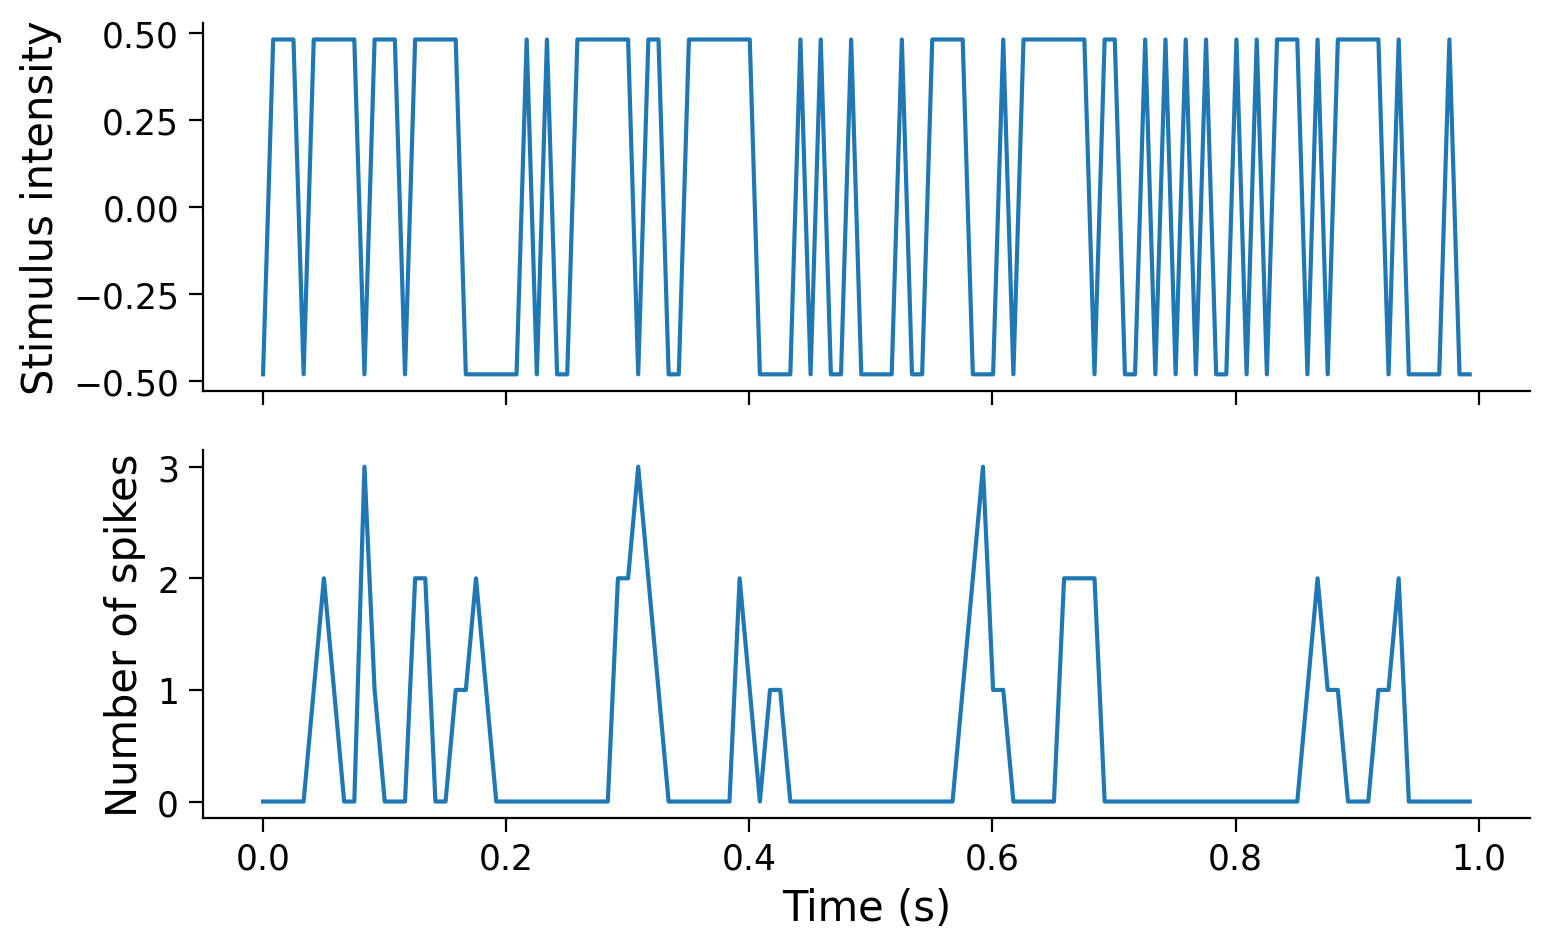

In [7]:
plot_stim_and_spikes(stim, spikes, dt_stim)

### Create design matrix

Our goal is to predict the cell's activity from the stimulus intensities preceding it. That will help us understand how RGCs process information over time. To do so, we first need to create the *design matrix* for this model, which organizes the stimulus intensities in matrix form such that the $i$th row has the stimulus frames preceding timepoint $i$.

In this exercise, we will create the design matrix $\mathbf{X}$ using $d=25$ time lags. That is, $\mathbf{X}$ should be a $T \times d$ matrix. $d = 25$ (about 200 ms) is a choice we're making based on our prior knowledge of the temporal window that influences RGC responses. In practice, you might not know the right duration to use.

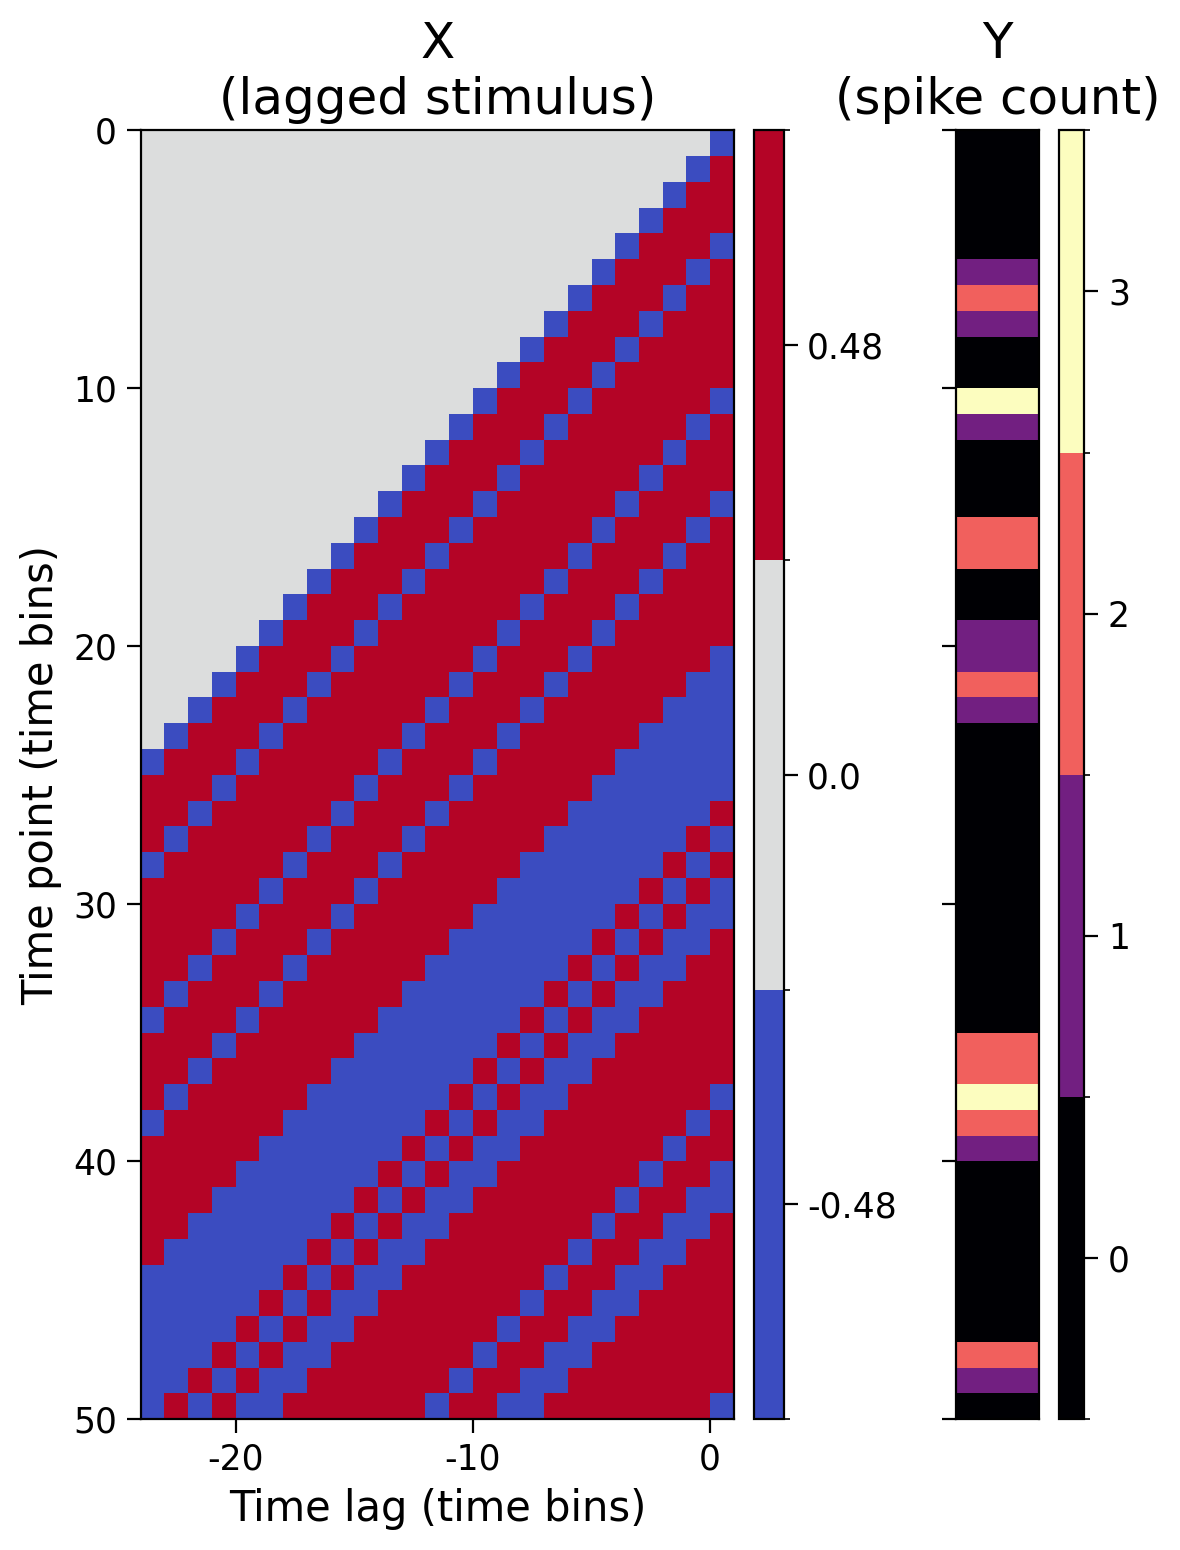

In [11]:
d = 25
# Construct a matrix where each row has the d frames of
# the stimulus preceding and including timepoint t
T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
X = np.zeros((T, d))
padded_stim = np.concatenate([np.zeros(d - 1), stim]) # add placeholder zeros to the earlest sliding windows

for t in range(T):
  X[t] = padded_stim[t:t+25]

# Visualize
plot_glm_matrices(X, spikes, nt=50)

### Fit Linear-Gaussian regression model

First, we will use the design matrix to compute the maximum likelihood estimate for a linear-Gaussian GLM (aka "general linear model"). The maximum likelihood estimate of $\theta$ in this model can be solved analytically using the equation:

\begin{equation}
\boldsymbol{\hat \theta} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{y}
\end{equation}



Note: Before we can apply this equation, we would need to augment the design matrix to account for the mean of $y$, because the spike counts are all $\geq 0$. We do this by adding a constant column of 1's to the design matrix, which will allow the model to learn an additive offset weight. We will refer to this additional weight as $b$ (for bias), although it is alternatively known as a "DC term" or "intercept".

In [12]:
# Build the full design matrix with the constant column
y = spikes
constant = np.ones_like(y)
X = np.column_stack([constant,X])

# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta_lg = theta[1:]

Plot the resulting maximum likelihood filter estimate (just the 25-element weight vector $\theta$ on the stimulus elements, not the DC term $b$).

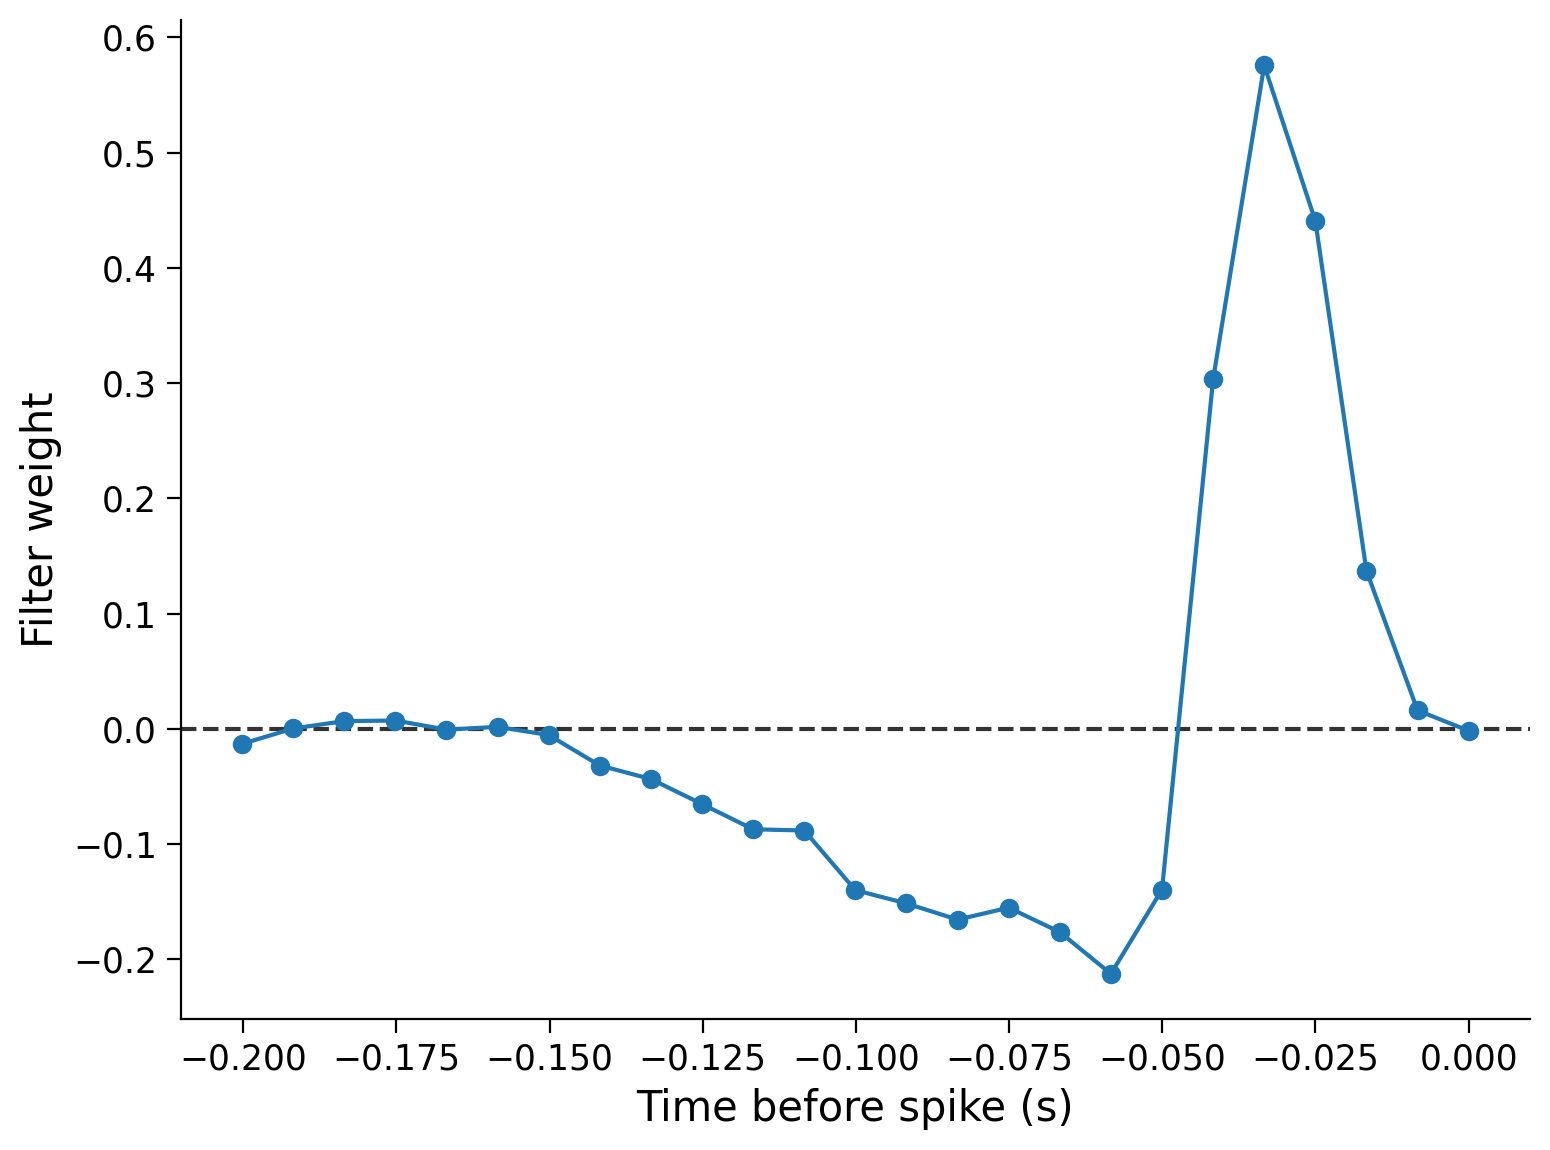

In [13]:
plot_spike_filter(theta_lg, dt_stim)

Now we can see how well our temporal filter model describe this neuron's firing patter by predicting the number of spikes.
- Obtain the MLE weights ($\boldsymbol{\hat \theta}$)
- Compute $\mathbf{\hat y} = \mathbf{X}\boldsymbol{\hat \theta}$

<ipython-input-3-e56ab4bb2568>:118: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  lines = ax.stem(t, spikes[:nt], use_line_collection=True)


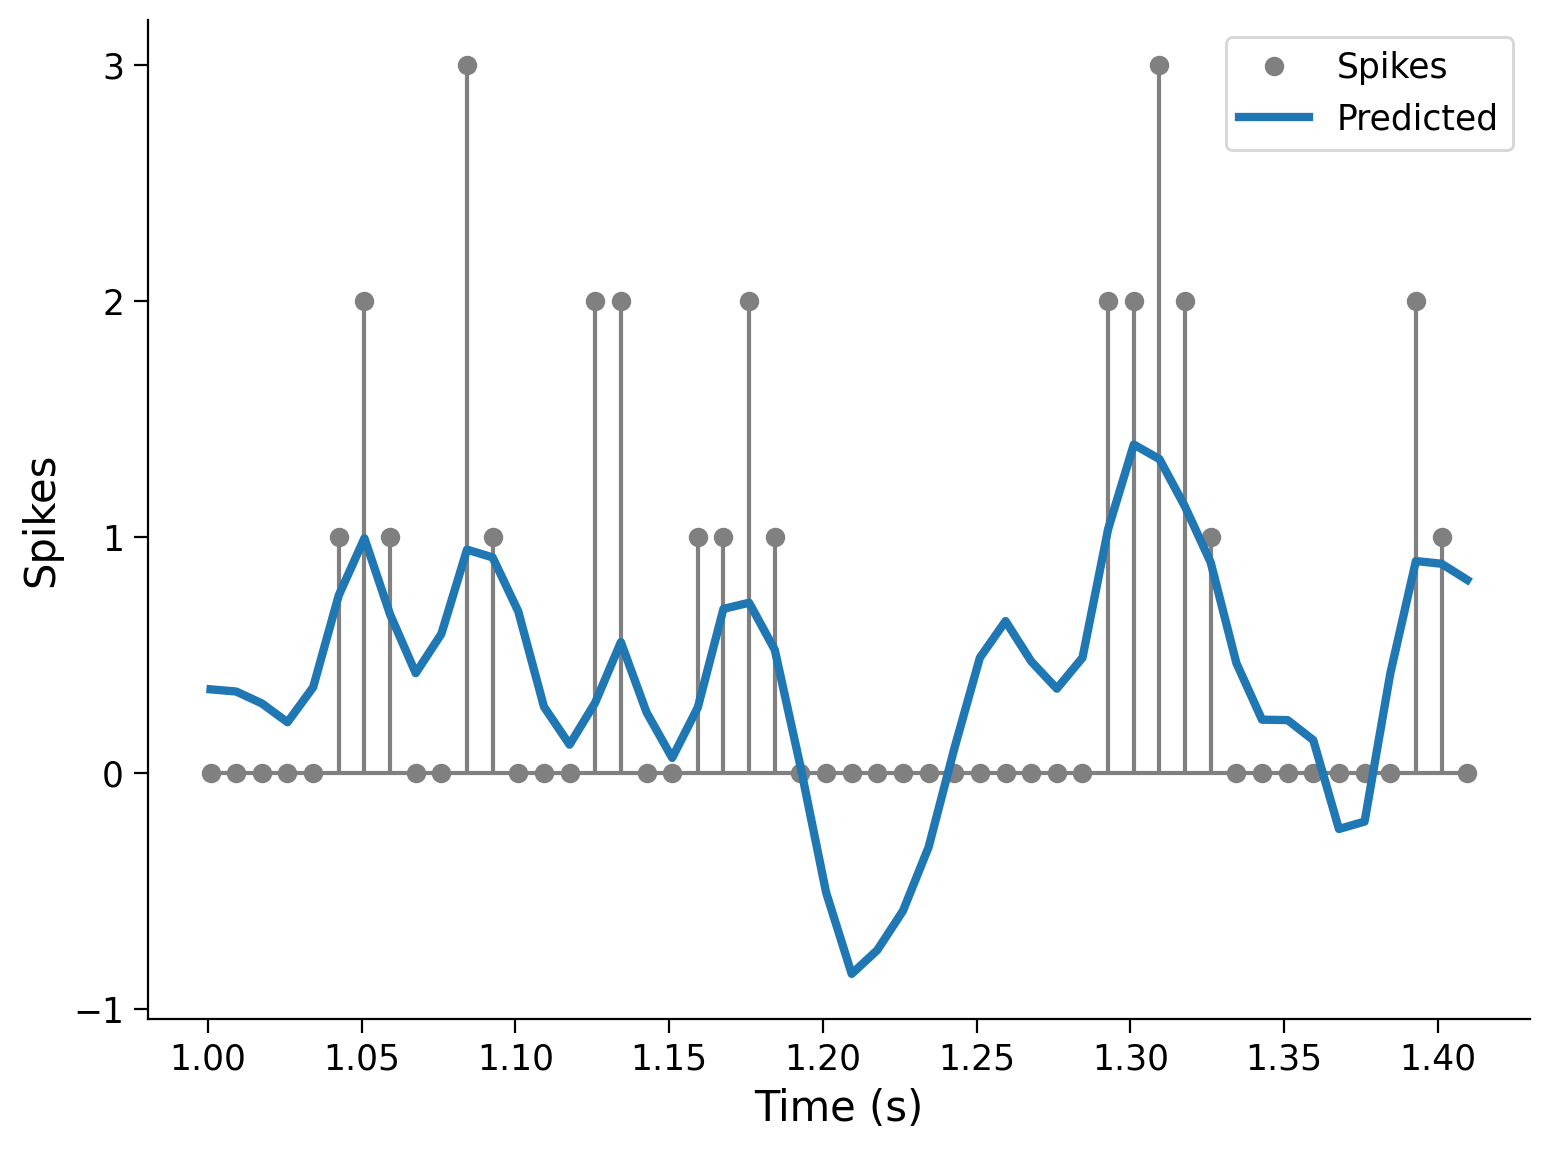

In [15]:
yhat = X @ theta

# Visualize
plot_spikes_with_prediction(spikes, yhat, dt_stim)

Is this a good model? The prediction line more-or-less follows the bumps in the spikes, but it never predicts as many spikes as are actually observed. And, more troublingly, it's predicting *negative* spikes for some time points.

The Poisson GLM will help to address these failures.

<br/>

---

### Linear-Nonlinear-Poisson GLM


In this exercise, we will use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to compute maximum likelihood estimates for the filter weights in the Poisson GLM model with an exponential nonlinearity (LNP: Linear-Nonlinear-Poisson).

In practice, this will involve filling out two functions.

- The first should be an *objective function* that takes a design matrix, a spike count vector, and a vector of parameters. It should return a negative log likelihood.
- The second function should take `stim` and `spikes`, build the design matrix and then use `minimize` internally, and return the MLE parameters.

What should the objective function look like? We want it to return the negative log likelihood: $-\log P(y \mid \mathbf{X}, \theta).$

In the Poisson GLM,

\begin{equation}
\log P(\mathbf{y} \mid \mathbf{X}, \theta) = \sum_t \log P(y_t \mid \mathbf{x_t},\theta),
\end{equation}

where

\begin{equation}
P(y_t \mid \mathbf{x_t}, \theta) = \frac{\lambda_t^{y_t}\exp(-\lambda_t)}{y_t!} \text{, with rate } \lambda_t = \exp(\mathbf{x_t}^{\top} \theta).
\end{equation}

Now, taking the log likelihood for all the data we obtain:

\begin{equation}
\log P(\mathbf{y} \mid X, \theta) = \sum_t( y_t \log\left(\lambda_t) - \lambda_t - \log(y_t !)\right).
\end{equation}

Because we are going to minimize the negative log likelihood with respect to the parameters $\theta$, we can ignore the last term that does not depend on $\theta$. For faster implementation, let us rewrite this in matrix notation:

\begin{equation}
\mathbf{y}^{\top} \log(\mathbf{\lambda}) - \mathbf{1}^{\top} \mathbf{\lambda} \text{, with  rate } \mathbf{\lambda} = \exp(\mathbf{X} \theta)
\end{equation}


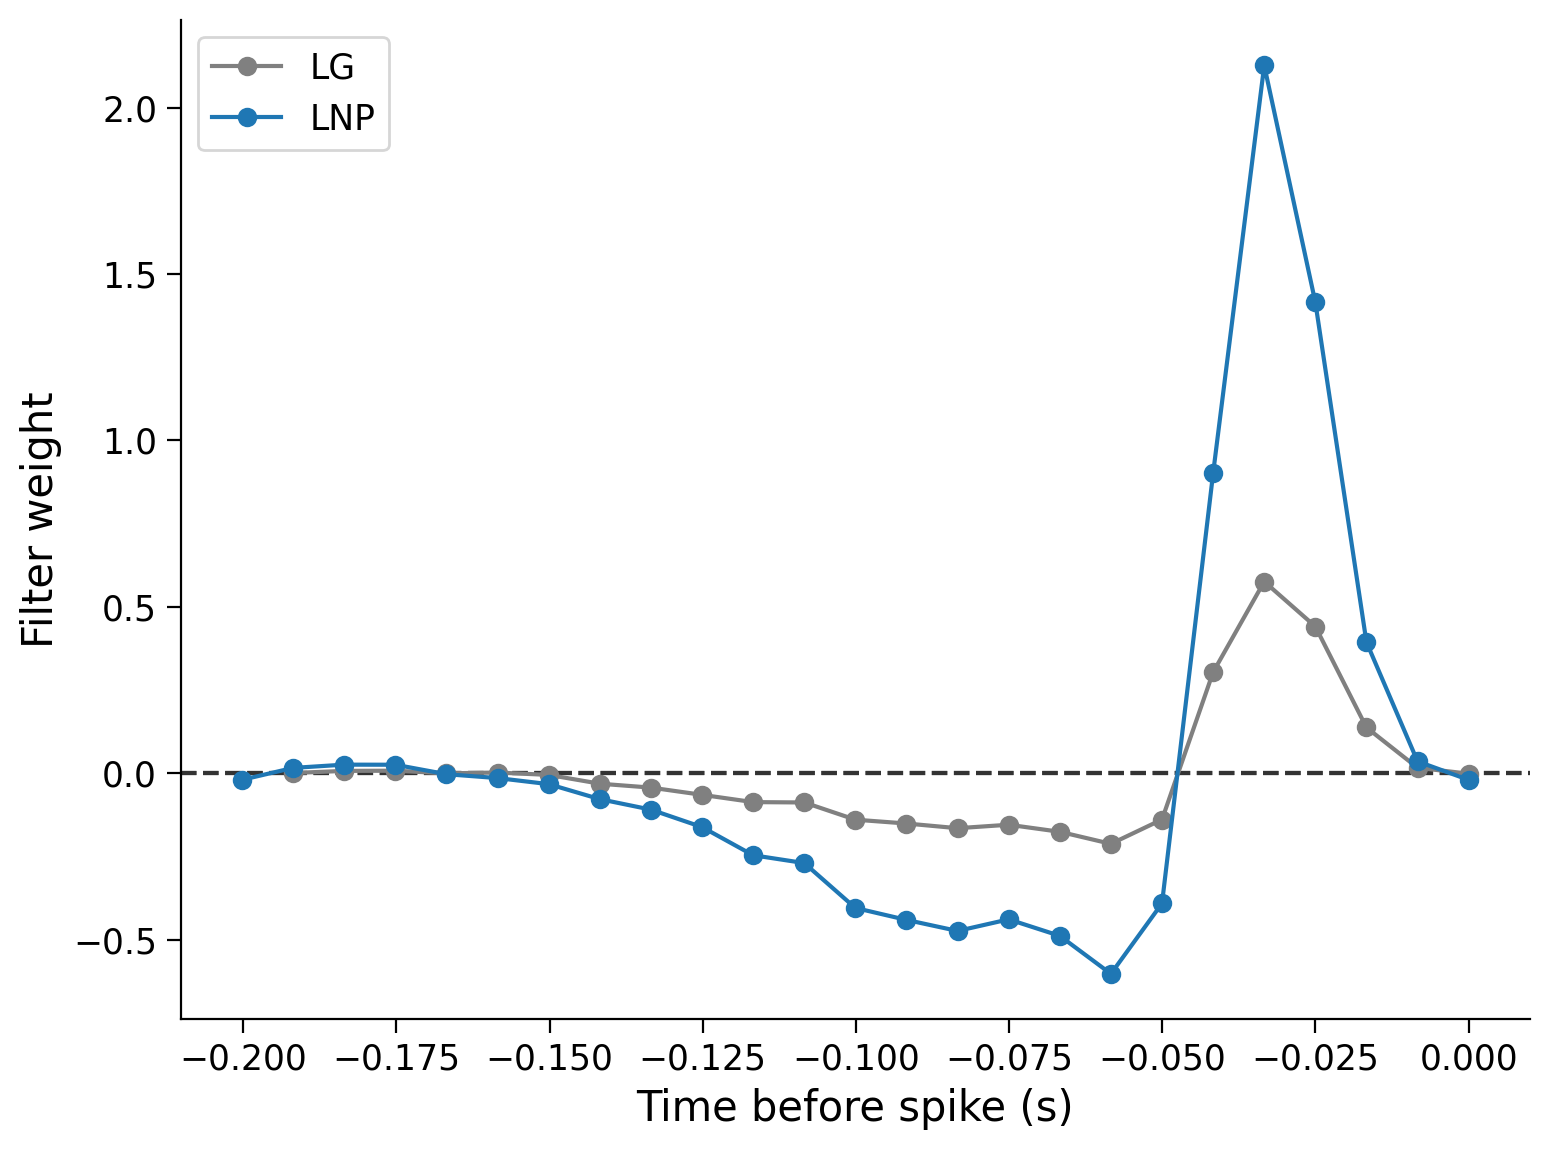

In [23]:
def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()

  return -log_lik


# Use a random vector of weights to start (mean 0, sd .2)
x0 = np.random.normal(0, .2, d + 1)

# Find parameters that minmize the negative log likelihood function
theta_lnp = minimize(neg_log_lik_lnp, x0, args=(X, y))

# Visualize
plot_spike_filter(theta_lg[1:], dt_stim, color=".5", label="LG")
plot_spike_filter(theta_lnp['x'][1:], dt_stim, label="LNP")
plt.legend(loc="upper left");

Plotting the LG and LNP weights together, we see that they are broadly similar, but the LNP weights are generally larger. What does that mean for the model's ability to *predict* spikes? To see that, let's finish the exercise by filling out the `predict_spike_counts_lnp` function:

<ipython-input-3-e56ab4bb2568>:118: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  lines = ax.stem(t, spikes[:nt], use_line_collection=True)


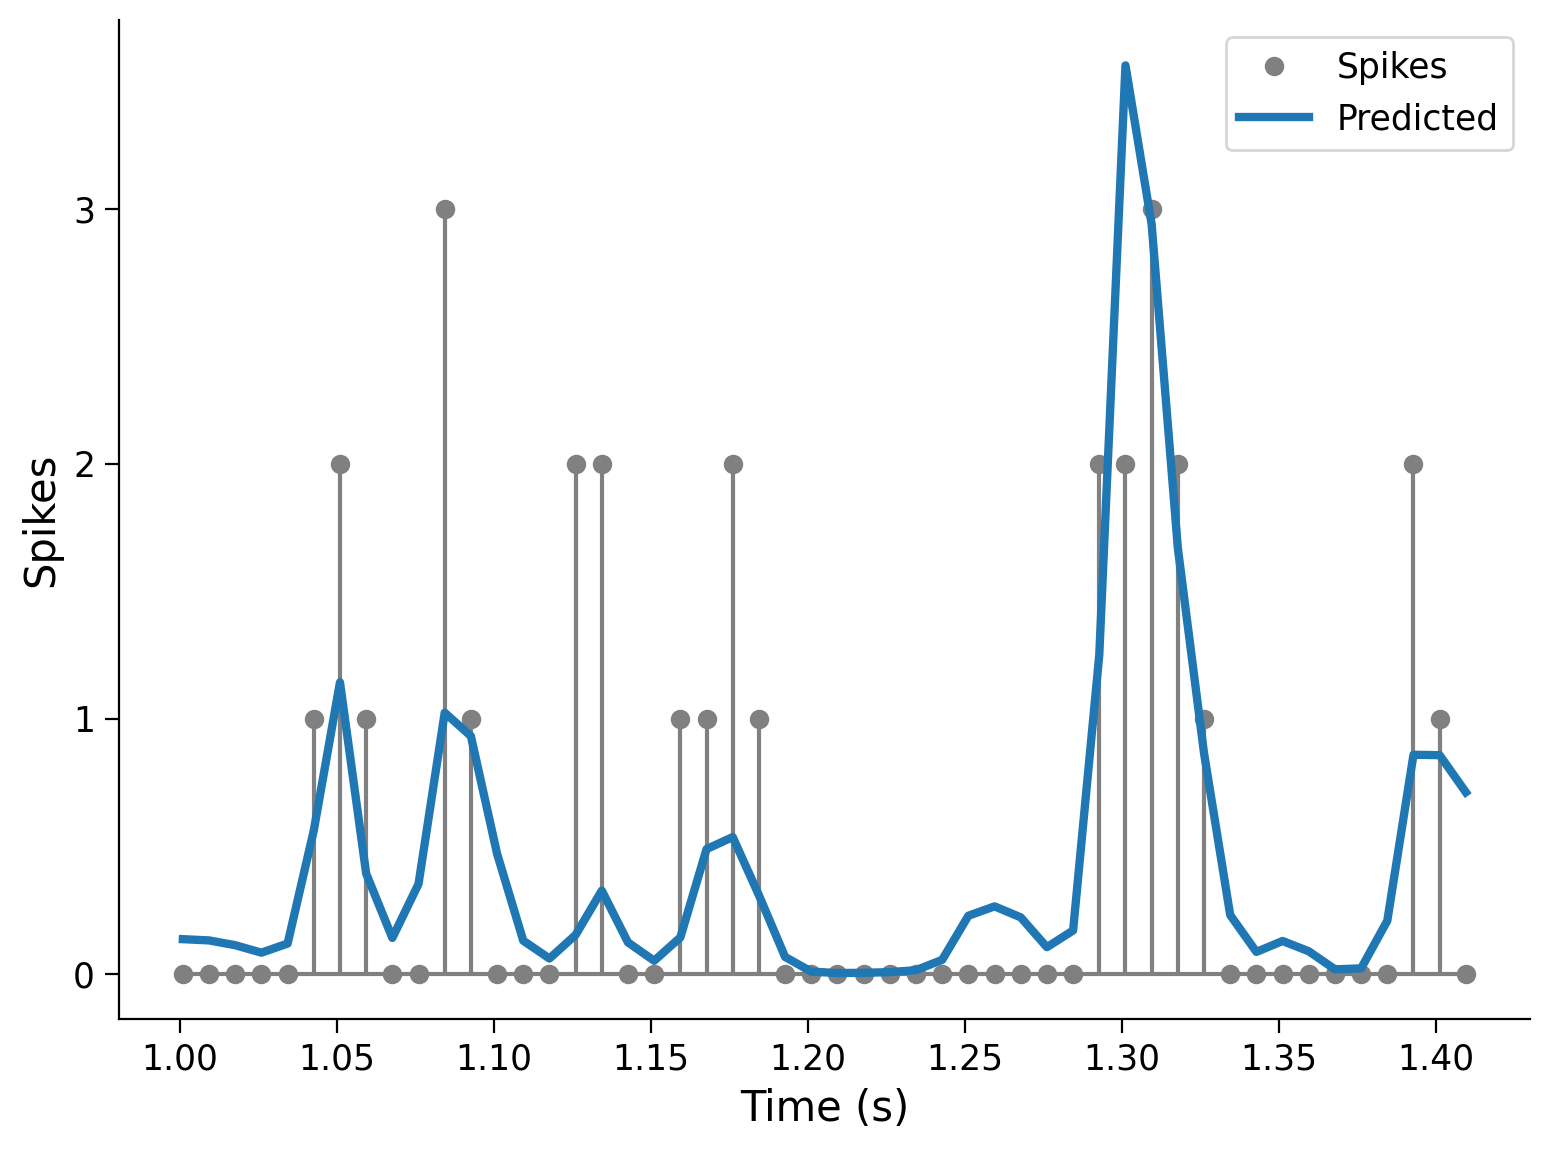

In [27]:
yhat = np.exp(X @ theta_lnp['x'])

# Visualize
plot_spikes_with_prediction(spikes, yhat, dt_stim)

We see that the LNP model does a better job of fitting the actual spiking data. Importantly, it never predicts negative spikes!